In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import dtreeviz

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_odds(x):
    return np.log((x==1).sum() / (x==0).sum())

def compute_residual(target, prob):
    return target - prob

def compute_leaf_output(model, data, residuals, probs):
    """Computes the gamma values for each leaf node in a weak learner."""
    leaf_idxs = model.apply(data) - 1
    num_leaves = model.get_n_leaves()
    gamma_n = np.zeros(num_leaves)
    gamma_d = np.zeros(num_leaves)
    if np.isscalar(probs):
        p = np.ones_like(residuals) * probs
    else:
        p = probs
    for i in range(num_leaves):
        sample_idxs = (leaf_idxs == i)
        n_samples = np.sum(sample_idxs)
        gamma_n[i] = np.sum(residuals[sample_idxs])
        gamma_d[i] = np.sum(p[sample_idxs] * (1 - p[sample_idxs]))

    gamma = gamma_n / gamma_d

    return gamma



f0 = 0.6931471805599453
p0 = 0.6666666666666666
r0 = [ 0.33333333 -0.66666667  0.33333333]


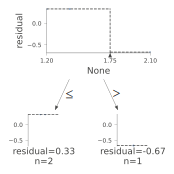

In [8]:
# Toy dataset from Raschka et al. (https://github.com/rasbt/machine-learning-book)
X = np.array([
    [1.12, 1.4],
    [2.45, 2.1],
    [3.54, 1.2]
])
y = np.array([1, 0, 1])

# 1. Create base classifier -- the log odds of the data
f0 = log_odds(y)
print(f"f0 = {f0}")

# 2. Create new weak learner by first converting original learner output into probabilities
p0 = sigmoid(f0)
print(f"p0 = {p0}")

# 2a. Compute residuals of the initial learner to use as targets to fit the new learner
r0 = compute_residual(y, p0)
print(f"r0 = {r0}")

# 2b. Fit a new learner using residuals
f1 = DecisionTreeRegressor(max_depth=1).fit(X, r0)

tree_vis = dtreeviz(f1, X, r0, target_name="residual")
tree_vis

Now that the weak learner is fit to the residuals, each leaf node is optimized to minimize the logistic loss function.

\begin{align*}
\gamma_{jm} &= \text{arg min}_y \sum_{x_i \in R_{jm}}L(y_i, F_{m-1}(x_i) + \gamma)\\
&= \log(1 + \exp(\hat{y}_i + \gamma)) - y_i(\hat{y}_i + \gamma)
\end{align*}

This does not have a closed form solution but can be approximated via [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

$$
\gamma_{jm} = \frac{\sum_i y_i - p_i}{\sum_i p_i(1 - p_i)}
$$

In [46]:
f1_out = compute_leaf_output(f1, X, r0, p0)

# Compute the boosted classifier F1 by combining the f0 and f1
eta = 0.1
leaf_idxs = f1.apply(X) - 1
f1_preds = f0 + eta * f1_out[leaf_idxs]
print(f"f1 predictions: {f1_preds}")

p1 = sigmoid(f1_preds)
print(f"f1 probabilities: {p1}")  # Note that these are higher for positive classes

r1 = compute_residual(y, p1)
print(f"f1 residuals: {r1}")  # These are also smaller

f1 predictions: [0.84314718 0.39314718 0.84314718]
f1 probabilities: [0.69912763 0.59704009 0.69912763]
f1 residuals: [ 0.30087237 -0.59704009  0.30087237]
